In [1]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-geometric

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

     |████████████████████████████████| 3.0 MB 8.8 MB/s 
     |████████████████████████████████| 1.6 MB 7.1 MB/s 
     |████████████████████████████████| 222 kB 8.1 MB/s 
     |████████████████████████████████| 376 kB 56.5 MB/s 
     |████████████████████████████████| 45 kB 3.0 MB/s 


# Node Classification with Graph Neural Networks



## Importing Data

In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...
Done!

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [4]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MLP, self).__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [28]:
import torch
import torch.nn as nn

class MLP(nn.Module):
  #def __init__ (self, in_channels,  hid_channels, hid_channels_2, out_channels):
  def __init__ (self, in_channels,  hid_channels, out_channels):
    super().__init__()
    torch.manual_seed(42)
    self.layer = nn.Sequential(
        nn.Linear(in_channels, hid_channels),
        nn.ReLU(inplace = True),
        #nn.functional
        nn.Dropout(),
        #nn.Linear(hid_channels, hid_channels_2),
        #nn.ReLU(inplace = True),
        #nn.functional
        #nn.Dropout(),
        # nn.Linear( hid_channels_2, out_channels),
        nn.Linear( hid_channels, out_channels),

    )

  def forward(self, x):
    return self.layer(x)
  

#model = MLP(in_channels = dataset.num_features, hid_channels=32,hid_channels_2 = 16, out_channels=dataset.num_classes)
model = MLP(in_channels = dataset.num_features, hid_channels=16, out_channels=dataset.num_classes)
print(model)


MLP(
  (layer): Sequential(
    (0): Linear(in_features=1433, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=16, out_features=7, bias=True)
  )
)


In [39]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# model = MLP(in_channels = dataset.num_features, hid_channels=16,hid_channels_2 = 8, out_channels=dataset.num_classes)
model = MLP(in_channels = dataset.num_features, hid_channels=16, out_channels=dataset.num_classes)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      #clear the gradient so that, loss from previous loop does not accumulate here
      optimizer.zero_grad() 
      # forward pass in simple terms y=wx getting y here.
      out = model(data.x) 
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9513
Epoch: 002, Loss: 1.9475
Epoch: 003, Loss: 1.9442
Epoch: 004, Loss: 1.9375
Epoch: 005, Loss: 1.9306
Epoch: 006, Loss: 1.9236
Epoch: 007, Loss: 1.9178
Epoch: 008, Loss: 1.9066
Epoch: 009, Loss: 1.8971
Epoch: 010, Loss: 1.8882
Epoch: 011, Loss: 1.8798
Epoch: 012, Loss: 1.8643
Epoch: 013, Loss: 1.8608
Epoch: 014, Loss: 1.8436
Epoch: 015, Loss: 1.8267
Epoch: 016, Loss: 1.8165
Epoch: 017, Loss: 1.7909
Epoch: 018, Loss: 1.7876
Epoch: 019, Loss: 1.7703
Epoch: 020, Loss: 1.7311
Epoch: 021, Loss: 1.7333
Epoch: 022, Loss: 1.7174
Epoch: 023, Loss: 1.7031
Epoch: 024, Loss: 1.6600
Epoch: 025, Loss: 1.6619
Epoch: 026, Loss: 1.6213
Epoch: 027, Loss: 1.6076
Epoch: 028, Loss: 1.5913
Epoch: 029, Loss: 1.5748
Epoch: 030, Loss: 1.5055
Epoch: 031, Loss: 1.4970
Epoch: 032, Loss: 1.4865
Epoch: 033, Loss: 1.4400
Epoch: 034, Loss: 1.4259
Epoch: 035, Loss: 1.3945
Epoch: 036, Loss: 1.3996
Epoch: 037, Loss: 1.3797
Epoch: 038, Loss: 1.3357
Epoch: 039, Loss: 1.2907
Epoch: 040, Loss: 1.2608


After training the model, we can call the `test` function to see how well our model performs on unseen labels.
Here, we are interested in the accuracy of the model, *i.e.*, the ratio of correctly classified nodes:

In [40]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5500


## Training a Graph Neural Network (GNN)

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.

Following-up on [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8), we replace the linear layers by the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module.
To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single linear layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.

In [91]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


Fix this 

In [90]:
# from torch_geometric.nn import GCNConv

# class GCN(nn.Module):
#   def  __init__(self, in_channels, hid_channels, out_channels):
#     super().__init__()
#     torch.manual_seed(42)
#     self.conv = nn.Sequential(
#         GCNConv(in_channels, hid_channels),
#         nn.ReLU(inplace = True),
#         nn.Dropout(),
#         GCNConv(hid_channels, out_channels),
#     )

#   def forward(self, x, edge_index):
#     x = self.conv(x,edge_index)
#     return x

# model = GCN(in_channels = 32, hid_channels = 16, out_channels = 1)
# print(model)


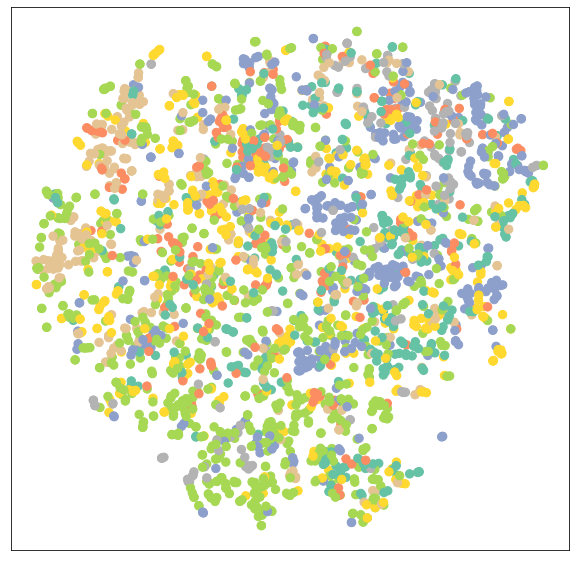

In [92]:
model = GCN(hidden_channels=16)
# model = GCN(in_channels = dataset.num_features, hid_channels = 16, out_channels = dataset.num_classes)

model.eval()
x = data.x
edges = data.edge_index
out = model(x, edges)
visualize(out, color=data.y)

In [93]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9451
Epoch: 002, Loss: 1.9384
Epoch: 003, Loss: 1.9307
Epoch: 004, Loss: 1.9227
Epoch: 005, Loss: 1.9126
Epoch: 006, Loss: 1.9076
Epoch: 007, Loss: 1.8917
Epoch: 008, Loss: 1.8809
Epoch: 009, Loss: 1.8728
Epoch: 010, Loss: 1.8616
Epoch: 011, Loss: 1.8453
Epoch: 012, Loss: 1.8397
Epoch: 013, Loss: 1.8237
Epoch: 014, Loss: 1.8057
Epoch: 015, Loss: 1.7979
Epoch: 016, Loss: 1.7808
Epoch: 017, Loss: 1.7667
Epoch: 018, Loss: 1.7555
Epoch: 019, Loss: 1.7436
Epoch: 020, Loss: 1.7184
Epoch: 021, Loss: 1.7126
Epoch: 022, Loss: 1.6845
Epoch: 023, Loss: 1.6717
Epoch: 024, Loss: 1.6673
Epoch: 025, Loss: 1.6353
Epoch: 026, Loss: 1.6181
Epoch: 027, Loss: 1.5962
Epoch: 028, Loss: 1.5723
Epoch: 029, Loss: 1.5708
Epoch: 030, Loss: 1.5370
Epoch: 031, Loss: 1.5162
Epoch: 032, Loss: 1.4948
Epoch: 033, Loss: 1.4713
Epoch: 034, Loss: 1.4589
Epoch: 035, Loss: 1.4479
Epoch: 036, Loss: 1.4377
Epoch: 037, Loss: 1.4271
Epoch: 038, Loss: 1.3644
Epoch: 039, Loss: 1.3658
Epoch: 040, Loss: 1.3363


After training the model, we can check its test accuracy:

In [94]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8140


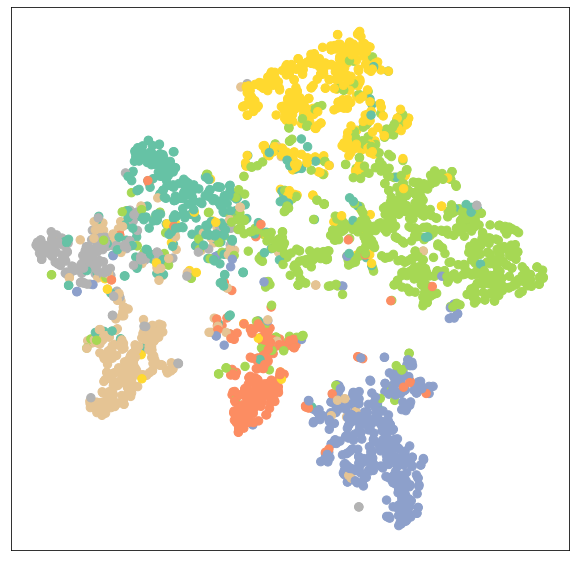

In [95]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

Trying to increase the accuracy

In [ ]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)